In [1]:
import numpy as np
!pip install gymnasium
import gymnasium as gym
!pip install ale_py
import ale_py
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import HTML, display, clear_output
from matplotlib import animation
from collections import deque, defaultdict
import pickle
from tqdm import tqdm
import pandas as pd
from random import random
import os
from datetime import datetime
import warnings
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings("ignore")

# To plot pretty figures
#%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.7 MB/s eta 0:00:0000:010:01


In [2]:
def resize_frame(frame):
    #frame = frame[30:-12,5:-4] # no need to crop
    frame = np.average(frame,axis = 2) # convert to grayscale
    frame = cv2.resize(frame,(84,84),interpolation = cv2.INTER_NEAREST) # resize to 84x84
    frame = np.array(frame,dtype = np.uint8) # convert to uint8
    return frame

In [3]:
class Memory():
    def __init__(self,max_len):
        self.max_len = max_len
        self.frames = deque(maxlen = max_len)
        self.actions = deque(maxlen = max_len)
        self.rewards = deque(maxlen = max_len)
        self.done_flags = deque(maxlen = max_len)

    def add_experience(self,next_frame, next_frames_reward, next_action, next_frame_terminal):
        self.frames.append(next_frame)
        self.actions.append(next_action)
        self.rewards.append(next_frames_reward)
        self.done_flags.append(next_frame_terminal)

In [4]:
def initialize_new_game(name, env, agent):
    """We don't want an agents past game influencing its new game, so we add in some dummy data to initialize"""
    
    env.reset()
    starting_frame = resize_frame(env.step(0)[0])

    dummy_action = 0
    dummy_reward = 0
    dummy_done = False
    for _ in range(3):
        agent.memory.add_experience(starting_frame, dummy_reward, dummy_action, dummy_done)

def make_env(name):
    env = gym.make(name, render_mode='rgb_array')
    # env = gym.make(name, frameskip=1, render_mode='rgb_array')
    # env = gym.wrappers.AtariPreprocessing(env, frame_skip=4, screen_size=84)
    return env

def take_step(name, env, agent, score, lives, debug):
    
    #1 and 2: Update timesteps and save weights
    agent.total_timesteps += 1
    if agent.total_timesteps % 10000 == 0:
      agent.model.save_weights('recent.weights.h5')
      print('\nWeights saved!')

    #3: Take action
    next_frame, next_frames_reward, next_frame_terminal, _, info = env.step(agent.memory.actions[-1])
    next_lives = info['lives']

    #4: Get next state
    next_frame = resize_frame(next_frame)
    new_state = [agent.memory.frames[-3], agent.memory.frames[-2], agent.memory.frames[-1], next_frame]
    new_state = np.moveaxis(new_state,0,2)/255 #We have to do this to get it into keras's goofy format of [batch_size,rows,columns,channels]
    new_state = np.expand_dims(new_state,0) #^^^
    
    #5: Get next action, using next state
    next_action = agent.get_action(new_state)

    #6: Now we add the next experience to memory
    lost_life_penalty = 0.01 if lives == next_lives else -20
    agent.memory.add_experience(next_frame, next_frames_reward + lost_life_penalty, next_action, next_frame_terminal)
    
    #7: If game is over, return the score
    if next_frame_terminal:
        return (score + next_frames_reward),True, next_lives

    #8: If we are trying to debug this then render
    if debug:
        img = env.render()
        global frames
        frames.append(img)

    #9: If the threshold memory is satisfied, make the agent learn from memory
    if len(agent.memory.frames) > agent.starting_mem_len:
        agent.learn(debug)

    return (score + next_frames_reward),False, next_lives

def play_episode(name, env, agent, debug = False):
    initialize_new_game(name, env, agent)
    done = False
    score = 0
    lives = 4
    while True:
        score, done, lives = take_step(name,env,agent,score, lives, debug)
        if done:
            break
    return score

In [5]:
class Agent():
    def __init__(self,possible_actions,starting_mem_len,max_mem_len,starting_epsilon,learn_rate, starting_lives = 4, debug = False):
        self.memory = Memory(max_mem_len)
        self.possible_actions = possible_actions
        self.epsilon = starting_epsilon
        self.epsilon_decay = .9/100000
        self.epsilon_min = .05
        self.gamma = .95
        self.learn_rate = learn_rate
        self.model = self._build_model()
        self.model_target = clone_model(self.model)
        self.total_timesteps = 0
        self.lives = starting_lives
        self.starting_mem_len = starting_mem_len
        self.learns = 0


    def _build_model(self):
        model = Sequential()
        model.add(Input((84,84,4)))
        model.add(Conv2D(filters = 32,kernel_size = (8,8),strides = 4,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Conv2D(filters = 64,kernel_size = (4,4),strides = 2,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Conv2D(filters = 64,kernel_size = (3,3),strides = 1,data_format="channels_last", activation = 'relu',kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Flatten())
        model.add(Dense(512,activation = 'relu', kernel_initializer = tf.keras.initializers.VarianceScaling(scale=2)))
        model.add(Dense(len(self.possible_actions), activation = 'linear'))
        optimizer = Adam(self.learn_rate)
        model.compile(optimizer, loss=tf.keras.losses.Huber())
        model.summary()
        print('\nAgent Initialized\n')
        return model

    def get_action(self,state):
        """Explore"""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.possible_actions)

        """Do Best Acton"""
        with tf.device(device):
            a_index = np.argmax(self.model.predict(state, verbose=0))
        return self.possible_actions[a_index]

    def _index_valid(self,index):
        if self.memory.done_flags[index-3] or self.memory.done_flags[index-2] or self.memory.done_flags[index-1] or self.memory.done_flags[index]:
            return False
        else:
            return True

    def learn(self,debug = False):
        """we want the output[a] to be R_(t+1) + Qmax_(t+1)."""
        """So target for taking action 1 should be [output[0], R_(t+1) + Qmax_(t+1), output[2]]"""

        """First we need 32 random valid indicies"""
        states = []
        next_states = []
        actions_taken = []
        next_rewards = []
        next_done_flags = []

        while len(states) < 32:
            index = np.random.randint(4,len(self.memory.frames) - 1)
            if self._index_valid(index):
                state = [self.memory.frames[index-3], self.memory.frames[index-2], self.memory.frames[index-1], self.memory.frames[index]]
                state = np.moveaxis(state,0,2)/255
                next_state = [self.memory.frames[index-2], self.memory.frames[index-1], self.memory.frames[index], self.memory.frames[index+1]]
                next_state = np.moveaxis(next_state,0,2)/255

                states.append(state)
                next_states.append(next_state)
                actions_taken.append(self.memory.actions[index])
                next_rewards.append(self.memory.rewards[index+1])
                next_done_flags.append(self.memory.done_flags[index+1])

        """Now we get the ouputs from our model, and the target model. We need this for our target in the error function"""
        with tf.device(device):
            labels = self.model.predict(np.array(states), verbose=0)
            next_state_values = self.model_target.predict(np.array(next_states), verbose=0)
        
        """Now we define our labels, or what the output should have been
           We want the output[action_taken] to be R_(t+1) + Qmax_(t+1) """
        for i in range(32):
            action = self.possible_actions.index(actions_taken[i])
            # since it is taken from memory, next_rewards is already adjusted for lost lives
            labels[i][action] = next_rewards[i] + (not next_done_flags[i]) * self.gamma * max(next_state_values[i])

        """Train our model using the states and outputs generated"""
        with tf.device(device):
            self.model.fit(np.array(states),labels,batch_size = 32, epochs = 1, verbose = 0)

        """Decrease epsilon and update how many times our agent has learned"""
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay
        self.learns += 1
        
        """Every 10000 learned (originally), copy our model weights to our target model"""
        if self.learns % 10000 == 0:
            self.model_target.set_weights(self.model.get_weights())
            print('\nTarget model updated')

In [10]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [11]:
name = 'ALE/Pacman-v5'

device = '/GPU:0' if tf.config.experimental.list_physical_devices('GPU') else '/CPU:0'

agent = Agent(possible_actions=[0,1,2,3,4],starting_mem_len=50000,max_mem_len=750000,starting_epsilon = 1, learn_rate = .0005)
gym.register_envs(ale_py)
env = make_env(name)

last_100_avg = [-41]
scores = deque(maxlen = 100)
all_scores = []
max_score = -41
 
env.reset()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 20, 20, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 9, 9, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,606,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,686,693 (6.43 MB)

 Trainable params: 1,686,693 (6.43 MB)

 Non-trainable params: 0 (0.00 B)


Agent Initialized



(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 {'lives': 4, 'episode_frame_number': 16, 'frame_number': 32})

In [12]:
# only when continuing training
# if os.path.exists('recent.weights.h5'):
#     agent.model.load_weights('recent.weights.h5')
#     agent.model_target.load_weights('recent.weights.h5')
#     print('\nWeights loaded!')
# else:
#     print('\nNo weights found')
# agent.epsilon = 0 # Set the epsilon at the value you had when you stopped training

  9%|▉         | 22/250 [00:19<03:24,  1.12it/s]


Weights saved!


 18%|█▊        | 45/250 [00:38<02:57,  1.15it/s]


Weights saved!


 28%|██▊       | 69/250 [01:07<02:22,  1.27it/s]


Weights saved!


 37%|███▋      | 93/250 [01:27<02:14,  1.17it/s]


Weights saved!


 40%|████      | 100/250 [01:33<02:21,  1.06it/s]

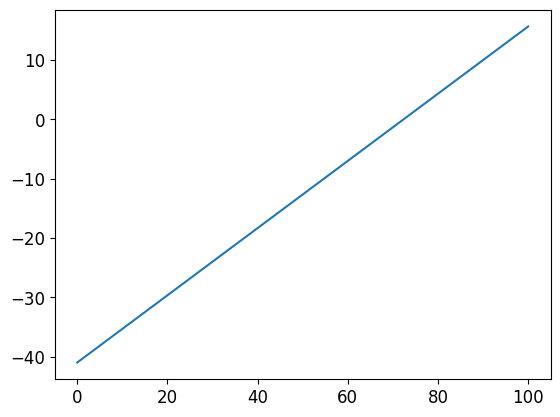

 47%|████▋     | 117/250 [02:15<13:40,  6.17s/it]


Weights saved!


 56%|█████▌    | 139/250 [31:32<2:25:41, 78.75s/it]


Target model updated


 56%|█████▌    | 140/250 [33:03<2:30:45, 82.24s/it]


Weights saved!


 65%|██████▌   | 163/250 [1:03:00<1:48:10, 74.60s/it]


Target model updated


 66%|██████▌   | 164/250 [1:04:25<1:51:18, 77.65s/it]


Weights saved!


 75%|███████▍  | 187/250 [1:36:25<1:28:40, 84.45s/it]


Target model updated

Weights saved!


 80%|████████  | 200/250 [1:56:08<1:07:28, 80.97s/it] 

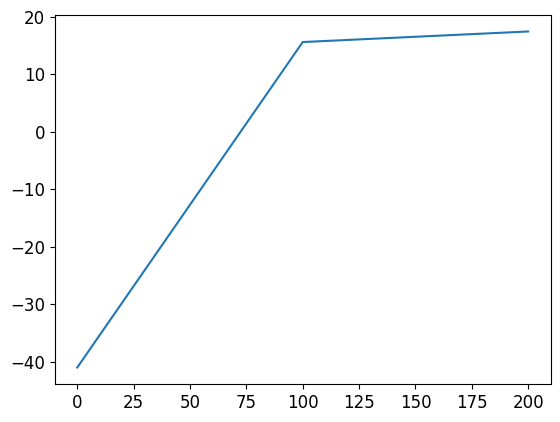

 83%|████████▎ | 208/250 [2:08:47<1:00:29, 86.41s/it]


Target model updated

Weights saved!


 90%|█████████ | 226/250 [2:42:08<40:20, 100.87s/it]  


Target model updated


 91%|█████████ | 227/250 [2:43:29<36:24, 94.96s/it] 


Weights saved!


 98%|█████████▊| 245/250 [3:17:00<09:36, 115.26s/it]


Target model updated


 98%|█████████▊| 246/250 [3:18:16<06:53, 103.45s/it]


Weights saved!


100%|██████████| 250/250 [3:25:38<00:00, 49.35s/it] 


In [13]:
for i in tqdm(range(250)):
    frames = [] # Saving the frames for the gif
    timesteps = agent.total_timesteps
    timee = time.time()
    score = play_episode(name, env, agent, debug = True) #set debug to true for rendering
    scores.append(score)
    all_scores.append(score)
    if score > max_score:
        max_score = score

    # print('\nEpisode: ' + str(i))
    # print('Steps: ' + str(agent.total_timesteps - timesteps))
    # print('Duration: ' + str(time.time() - timee))
    # print('Score: ' + str(score))
    # print('Max Score: ' + str(max_score))
    # print('Epsilon: ' + str(agent.epsilon))
    
    if i%50==0 and i!=0:
        anim = plot_animation(frames)
        anim.save("pacman{}.gif".format(i), dpi=100, writer= animation.PillowWriter(fps=20))# Saving the gif
        
    if i%100==0 and i!=0:
        last_100_avg.append(sum(scores)/len(scores))
        plt.plot(np.arange(0,i+1,100),last_100_avg)
        plt.show()

In [14]:
agent.model.save_weights('recent.weights.h5')
agent.model_target.save_weights('recent_target.weights.h5')
print('\nWeights saved!')


Weights saved!


In [15]:
frames = [] # Saving the frames for the gif
timesteps = agent.total_timesteps
score = play_episode(name, env, agent, debug = True) #set debug to true for rendering
scores.append(score)
all_scores.append(score)
if score > max_score:
    max_score = score

anim = plot_animation(frames)
anim.save("pacman{}.gif".format(i), dpi=100, writer= animation.PillowWriter(fps=20))# Saving the gif

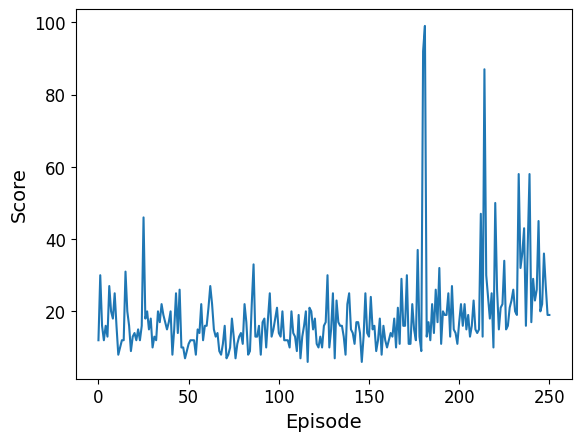

In [16]:
# plot all scores obtained
plt.plot(np.arange(len(all_scores)),all_scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.show()